In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo

plt.rcParams.update({'font.size': 12})

# Data Collection

Text(0, 0.5, 'Temperature [°C]')

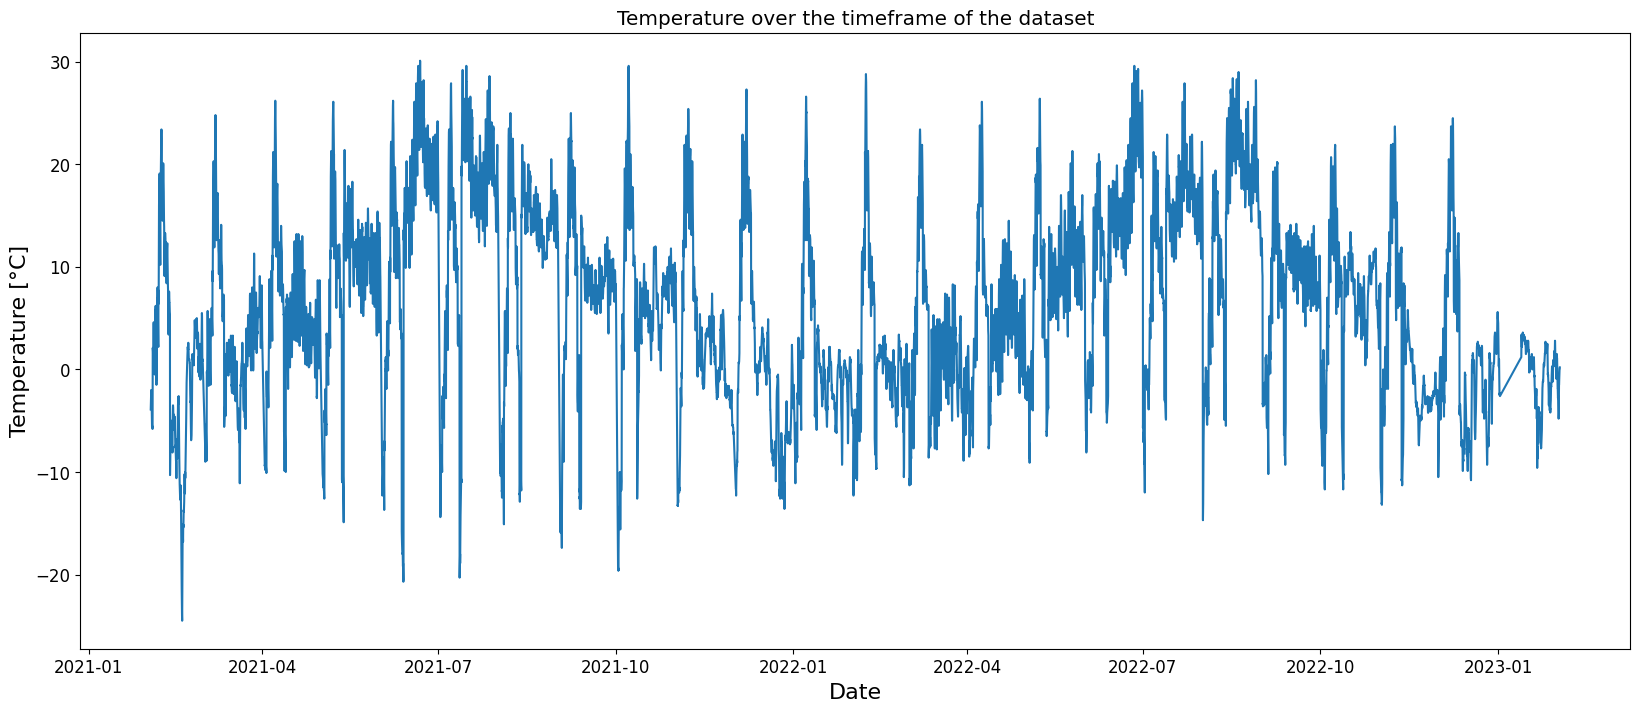

In [147]:
# import dataset and transform timestamp
df = pd.read_csv('data/solar_243171.csv', delimiter=',', decimal='.')
df['ts'] = df['timestamp']
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True).map(lambda x: x.tz_convert('Europe/Tallinn'))

# check for duplicate ts
if pd.Series(df["timestamp"]).is_unique:
    df.set_index('timestamp', inplace=True)

# show temperature first
plt.figure(figsize=(20,8))
plt.title("Temperature over the timeframe of the dataset")
p = sns.lineplot(data=df['temperature'])
p.set_xlabel("Date", fontsize=16)
p.set_ylabel("Temperature [°C]", fontsize=16)

## Find missing records

Checks time deltas for each record to see if hourly data is missing

In [148]:
# check timestamp steps (search if ts are missing)
full_timeindex = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h', tz="Europe/Tallinn")

dfi = pd.DataFrame(df.index)

#troubleshooting indices by inspecting irregularities of order. Header is printed first
print('Index,   current value,   last value,  value delta')

#collecting important values of irregular indices (index value and timedelta) for later use
idc = []

#iterating through datetime indices
for idx in range(1,len(df)):
    
    #if statement is True, if difference between consecutive datetime indices is not one hour
    if dfi.iloc[idx,0] - dfi.iloc[idx-1,0] != timedelta(hours=1):
        
        #appending collection of important values
        idc.append([idx,dfi.loc[idx] - dfi.loc[idx-1]])
        
        #printing values according to header
        print('{},   {},   {},   {}'.format(idx, dfi.iloc[idx,0], dfi.iloc[idx-1,0], dfi.iloc[idx,0]-dfi.iloc[idx-1,0]))

filled_data = df.reindex(full_timeindex)
filled_data[['raw', 'temperature']] = filled_data[['raw', 'temperature']].fillna(filled_data.shift(24)) # fill the 1 day gaps
filled_data[['raw', 'temperature']] = filled_data[['raw', 'temperature']].fillna(filled_data.shift(240)) # fill the remaining 10 day gap
filled_data.info()

Index,   current value,   last value,  value delta
648,   2021-03-02 02:00:00+02:00,   2021-03-01 01:00:00+02:00,   1 days 01:00:00
1368,   2021-04-02 03:00:00+03:00,   2021-04-01 02:00:00+03:00,   1 days 01:00:00
2064,   2021-05-02 03:00:00+03:00,   2021-05-01 02:00:00+03:00,   1 days 01:00:00
2784,   2021-06-02 03:00:00+03:00,   2021-06-01 02:00:00+03:00,   1 days 01:00:00
3480,   2021-07-02 03:00:00+03:00,   2021-07-01 02:00:00+03:00,   1 days 01:00:00
4200,   2021-08-02 03:00:00+03:00,   2021-08-01 02:00:00+03:00,   1 days 01:00:00
4920,   2021-09-02 03:00:00+03:00,   2021-09-01 02:00:00+03:00,   1 days 01:00:00
5616,   2021-10-02 03:00:00+03:00,   2021-10-01 02:00:00+03:00,   1 days 01:00:00
6336,   2021-11-02 02:00:00+02:00,   2021-11-01 01:00:00+02:00,   1 days 01:00:00
7032,   2021-12-02 02:00:00+02:00,   2021-12-01 01:00:00+02:00,   1 days 01:00:00
16536,   2023-01-13 02:00:00+02:00,   2023-01-02 01:00:00+02:00,   11 days 01:00:00
<class 'pandas.core.frame.DataFrame'>
Datetime

In [149]:
# check if all values in the modified columns are actaully the same as in raw (if they are there)
no_mismatch_modified_1 = ((df['raw'] == df['modified1']) | (df['modified1'].isna())).all()
no_mismatch_modified_2 = ((df['raw'] == df['modified1']) | (df['modified1'].isna())).all()
no_mismatch_modified_3 = ((df['raw'] == df['modified1']) | (df['modified1'].isna())).all()

if no_mismatch_modified_1 and no_mismatch_modified_2 and no_mismatch_modified_3:
    print("All columns modified1, modified2, modified3 have the same value as raw IF their value is set!")


All columns modified1, modified2, modified3 have the same value as raw IF their value is set!


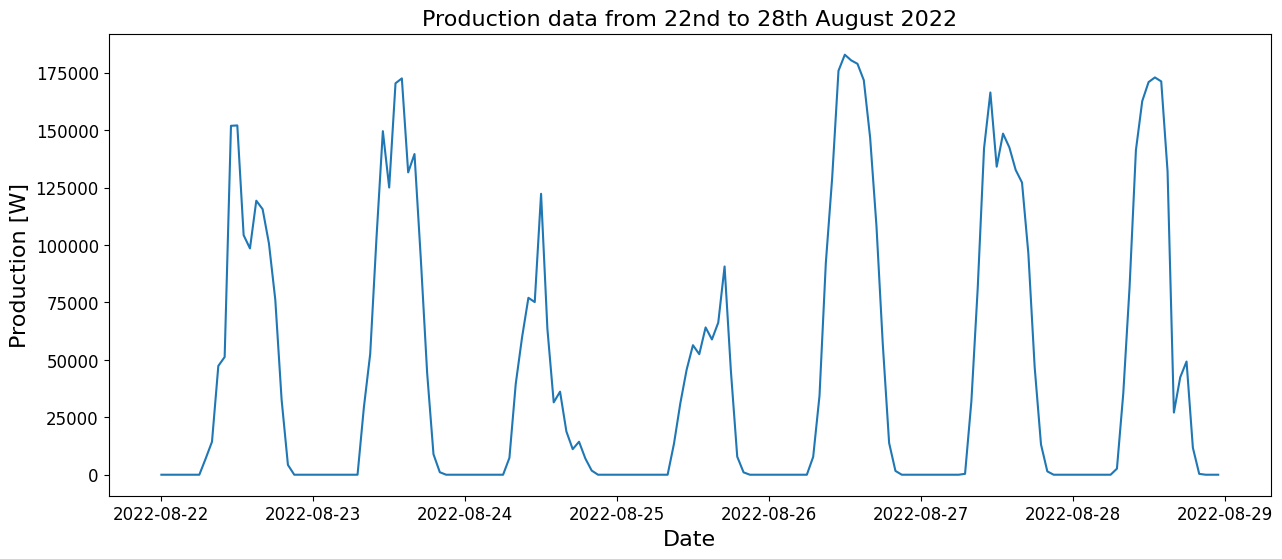

In [176]:

# check raw data over a week
start_date = datetime(2022, 8,22, tzinfo=ZoneInfo("Europe/Tallinn"))
end_date = datetime(2022, 8, 29, tzinfo=ZoneInfo("Europe/Tallinn"))

df_week = df[(df.index >= start_date) & (df.index < end_date)]

plt.figure(figsize=(15,6))
plt.title("Production data from 22nd to 28th August 2022", fontsize=16)
p = sns.lineplot(data=df_week['raw'])
#p = sns.lineplot(data=df_week['modified1'], label="modified1")
#p = sns.lineplot(data=df_week['modified2'], label="modified2")
#p = sns.lineplot(data=df_week['modified3'], label="modified3")
p.set_xlabel("Date", fontsize=16)
p.set_ylabel("Production [W]", fontsize=16)
plt.savefig("diagrams/diagram_production_data_week.pdf")


## Validate UNIX timestamps

Compare with another temperature dataset to validate the timestamps

In [151]:
# weather dataset for comparison -> are the timestamps in UNIX UTC?
df_weather = pd.read_csv('data/Tallinn-Harku-2004-juuni-2024.csv', delimiter=';', decimal=',') # source: https://www.ilmateenistus.ee/wp-content/uploads/2024/07/Tallinn-Harku-2004-juuni-2024.xlsx
df_weather['timestamp'] = pd.to_datetime(df_weather[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1) + ' ' + df_weather['time'], utc=True).map(lambda x: x.tz_convert('Europe/Tallinn'))
if pd.Series(df_weather["timestamp"]).is_unique:
    df_weather.set_index('timestamp', inplace=True)

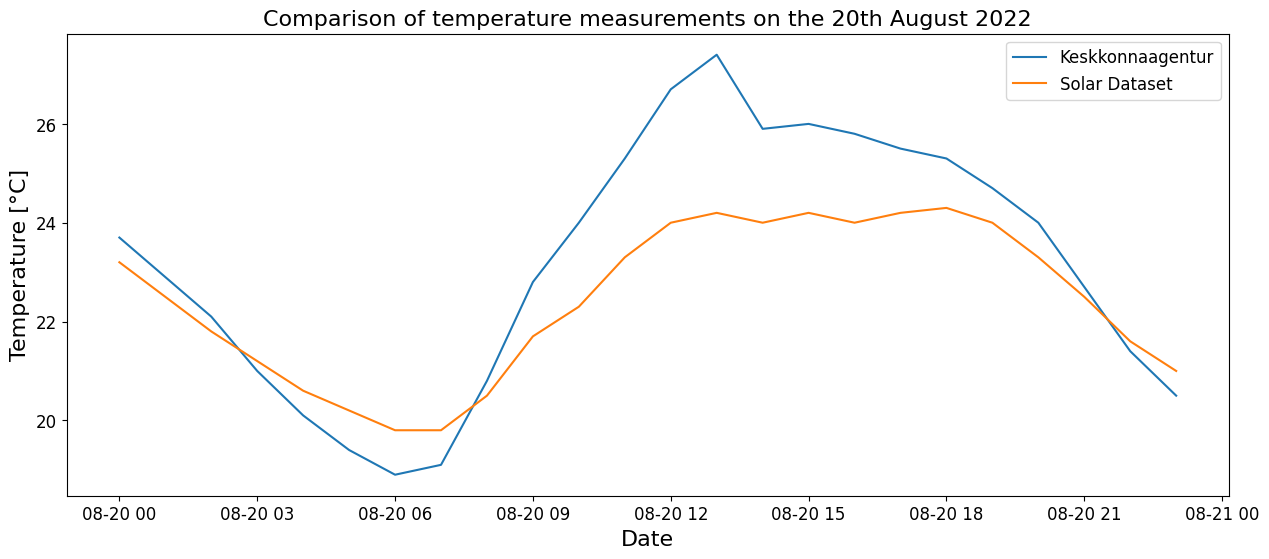

In [152]:
# comparison graph
start_date = datetime(2022, 8,20, tzinfo=ZoneInfo("Europe/Tallinn"))
end_date = datetime(2022, 8, 21, tzinfo=ZoneInfo("Europe/Tallinn"))

temperature_dataset = df['temperature'][(df.index >= start_date) &  (df.index < end_date)]
temperature_keskkonnaagentuur  = df_weather['temp'][(df_weather.index >= start_date) &  (df_weather.index < end_date)]

plt.figure(figsize=(15,6))
plt.title("Comparison of temperature measurements on the 20th August 2022", fontsize=16)
p = sns.lineplot(data=temperature_keskkonnaagentuur, label="Keskkonnaagentur")
p = sns.lineplot(data=temperature_dataset, label="Solar Dataset")
p.set_xlabel("Date", fontsize=16)
p.set_ylabel("Temperature [°C]", fontsize=16)
plt.savefig("diagrams/diagram_comparison_weather_data.pdf")

# Data cleaning
## Missing Data Mechanisms

In [153]:
# missing values
missing_values = df.isnull().sum()
missing_values

raw               0
temperature       0
modified1      1191
modified2      1375
modified3      1137
ts                0
dtype: int64

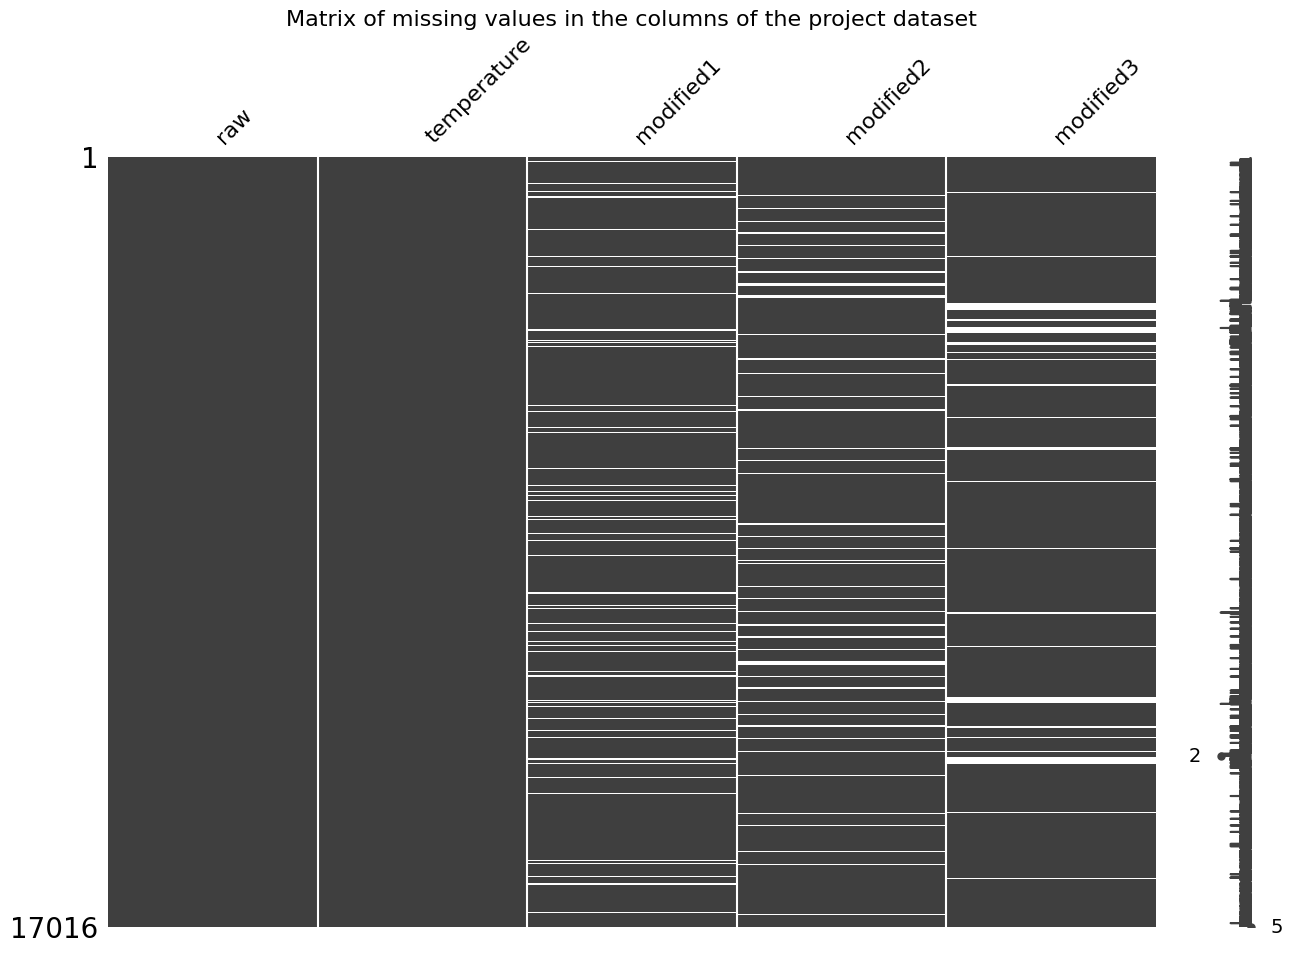

In [154]:
import missingno as msno

msno.matrix(df[["raw", "temperature", "modified1", "modified2", "modified3"]], figsize=(15,10))
plt.title("Matrix of missing values in the columns of the project dataset", fontsize=16)
plt.savefig("diagrams/matrix_missing_values.pdf")

In [155]:
# test if the temperature might influence the missing of data
no_modified_1 = df[df['modified1'].isnull()]
no_modified_2 = df[df['modified2'].isnull()]
no_modified_3 = df[df['modified3'].isnull()]

print("Mean, Std, Min of temperature during missing modified1 values:", no_modified_1['temperature'].mean(), no_modified_1['temperature'].std(), no_modified_1['temperature'].min())
print("Mean, Std, Min of temperature during missing modified2 values:", no_modified_2['temperature'].mean(), no_modified_2['temperature'].std(), no_modified_2['temperature'].min())
print("Mean, Std, Min of temperature during missing modified3 values:", no_modified_3['temperature'].mean(), no_modified_3['temperature'].std(), no_modified_3['temperature'].min())
print("Mean, Std, Min of temperature of whole dataset:",df['temperature'].mean(), df['temperature'].std(), df['temperature'].min())

print("Mean, Std, Min of raw during missing modified1 values:", no_modified_1['raw'].mean(), no_modified_1['raw'].std(), no_modified_1['raw'].min())
print("Mean, Std, Min of raw during missing modified2 values:", no_modified_2['raw'].mean(), no_modified_2['raw'].std(), no_modified_2['raw'].min())
print("Mean, Std, Min of raw during missing modified3 values:",no_modified_3['raw'].mean(), no_modified_3['raw'].std(), no_modified_3['raw'].min())
print("Mean, Std, Min of raw of whole dataset:",df['raw'].mean(), df['raw'].std(), df['raw'].min())

Mean, Std, Min of temperature during missing modified1 values: 6.486314021830394 9.254695238913758 -24.0
Mean, Std, Min of temperature during missing modified2 values: 10.246545454545455 9.879720642752384 -18.9
Mean, Std, Min of temperature during missing modified3 values: 24.03104661389622 2.2599728229953 21.1
Mean, Std, Min of temperature of whole dataset: 6.609191349318289 9.292033255121268 -24.5
Mean, Std, Min of raw during missing modified1 values: 31207.857506297227 59856.04952103751 0.0
Mean, Std, Min of raw during missing modified2 values: 166656.37769454543 87758.9772307748 660.08
Mean, Std, Min of raw during missing modified3 values: 78156.51364116094 77177.63983469969 0.0
Mean, Std, Min of raw of whole dataset: 36912.094887752704 66907.41034729625 0.0


## Missing Data Handling

In [156]:
modified_1 = df[['raw','temperature','modified1']]
modified_1_full = modified_1.copy()

missing = modified_1[modified_1.isnull()['modified1'] == True]

missing.describe()

,raw,temperature,modified1
count,1191.000000,1191.000000,0.0
mean,31207.857506,6.486314,NaN
std,59856.049521,9.254695,NaN
min,0.000000,-24.000000,NaN
25%,0.000000,-0.200000,NaN
50%,0.000000,6.500000,NaN
75%,30611.805000,13.400000,NaN
max,301335.730000,29.500000,NaN


In [157]:
# Method 1: Deletion

deletion_df = modified_1.dropna(subset=['modified1'])
deletion_df['absolute_error'] = (deletion_df['raw'] - deletion_df['modified1']).abs()
deletion_df.describe()

/tmp/ipykernel_3585/2612078159.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deletion_df['absolute_error'] = (deletion_df['raw'] - deletion_df['modified1']).abs()


,raw,temperature,modified1,absolute_error
count,15825.000000,15825.000000,15825.000000,15825.0
mean,37341.399578,6.618439,37341.399578,0.0
std,67390.437085,9.295063,67390.437085,0.0
min,0.000000,-24.500000,0.000000,0.0
25%,0.000000,-0.200000,0.000000,0.0
50%,0.000000,6.400000,0.000000,0.0
75%,39325.850000,13.400000,39325.850000,0.0
max,301630.010000,30.100000,301630.010000,0.0


In [158]:
# Method 2: Mean

mean_df = pd.DataFrame(modified_1['modified1'].fillna(modified_1['modified1'].mean()))
mean_df.rename(columns = {'modified1':'mean'}, inplace=True)

modified_1 = modified_1.join(mean_df['mean'])
missing = missing.join(mean_df['mean']) 

In [159]:
# Method 3: Linear Interpolation

linear_df = modified_1.interpolate(method ='linear', limit_direction ='forward', axis='columns')
linear_df.rename(columns = {'modified1':'li'}, inplace=True)
linear_df.describe()

modified_1 = modified_1.join(linear_df['li'])
missing = missing.join(linear_df['li'])

In [160]:
# Method 4: MICE

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer

#imputer = SimpleImputer(strategy='mean')
#imputer = SimpleImputer(strategy='median')
imputer = KNNImputer(n_neighbors=5)

imputed_values = imputer.fit_transform(modified_1.reset_index()[['modified1','temperature']])
imputed_values = pd.DataFrame(imputed_values[:,0])
imputed_values.set_index(modified_1.index, inplace=True)
imputed_values.rename(columns = {0:'mice'}, inplace=True)

modified_1 = modified_1.join(imputed_values['mice'])
missing = missing.join(imputed_values['mice'])

missing['err-mean'] = (missing['raw'] - missing['mean']).abs()
missing['err-li'] = (missing['raw'] - missing['li']).abs()
missing['err-mice'] = (missing['raw'] - missing['mice']).abs()
missing['err-sq-mean'] = missing['err-mean'].pow(2)
missing['err-sq-li'] = missing['err-li'].pow(2)
missing['err-sq-mice'] = missing['err-mice'].pow(2)
missing.describe()


,raw,temperature,modified1,mean,li,mice,err-mean,err-li,err-mice,err-sq-mean,err-sq-li,err-sq-mice
count,1191.000000,1191.000000,0.0,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1.191000e+03,1.191000e+03,1.191000e+03
mean,31207.857506,6.486314,NaN,37341.399578,18673.942946,36168.286339,46096.502868,37058.257082,44139.661209,3.617359e+09,3.736721e+09,4.215757e+09
std,59856.049521,9.254695,NaN,0.000000,4.627348,34319.929082,38648.744092,48635.301095,47637.722372,8.028275e+09,1.002987e+10,8.972341e+09
min,0.000000,-24.000000,NaN,37341.399578,18658.699789,0.000000,92.770422,185.700211,0.000000,8.606351e+03,3.448457e+04,0.000000e+00
25%,0.000000,-0.200000,NaN,37341.399578,18670.599789,6157.344000,36545.379578,18666.699789,7844.009000,1.335566e+09,3.484457e+08,6.153163e+07
50%,0.000000,6.500000,NaN,37341.399578,18673.949789,29805.378000,37341.399578,18672.549789,31379.542000,1.394380e+09,3.486641e+08,9.846757e+08
75%,30611.805000,13.400000,NaN,37341.399578,18677.399789,53964.134000,37341.399578,18680.824789,61415.322000,1.394380e+09,3.489732e+08,3.771842e+09
max,301335.730000,29.500000,NaN,37341.399578,18685.449789,165854.484000,263994.330422,282663.730211,291547.950000,6.969301e+10,7.989878e+10,8.500021e+10


In [161]:
modified_1.describe()
print("Absolute error of mean (deletion):", abs(modified_1['raw'].mean() - deletion_df['modified1'].mean()))
print("Absolute error of mean (mean imp.):", abs(modified_1['raw'].mean() - modified_1['mean'].mean()))
print("Absolute error of mean (li):", abs(modified_1['raw'].mean() - modified_1['li'].mean()))
print("Absolute error of mean (mice):", abs(modified_1['raw'].mean() - modified_1['mice'].mean()))

print("Absolute error of std (deletion):", abs(modified_1['raw'].std() - deletion_df['modified1'].std()))
print("Absolute error of std (mean imp.):", abs(modified_1['raw'].std() - modified_1['mean'].std()))
print("Absolute error of std (li):", abs(modified_1['raw'].std() - modified_1['li'].std()))
print("Absolute error of std (mice):", abs(modified_1['raw'].std() - modified_1['mice'].std()))

Absolute error of mean (deletion): 429.30469013038964
Absolute error of mean (mean imp.): 429.30469013038964
Absolute error of mean (li): 877.2856277251194
Absolute error of mean (mice): 347.1950364362856
Absolute error of std (deletion): 483.02673807587416
Absolute error of std (mean imp.): 1918.3236841439648
Absolute error of std (li): 1744.0290676743462
Absolute error of std (mice): 1286.9233492120693


## Data exploration and Feature engineering

In [162]:
df['raw'].describe() # statistics

count     17016.000000
mean      36912.094888
std       66907.410347
min           0.000000
25%           0.000000
50%           0.000000
75%       38258.015000
max      301630.010000
Name: raw, dtype: float64

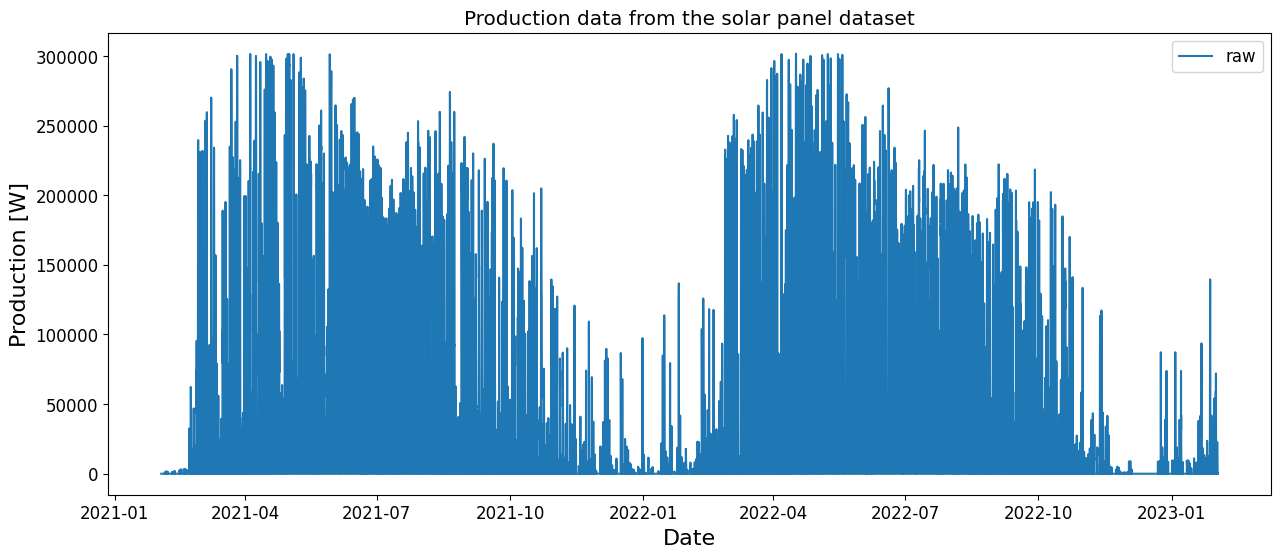

In [173]:
# check raw data

plt.figure(figsize=(15,6))
plt.title("Production data from the solar panel dataset")
p = sns.lineplot(data=df['raw'], label="raw")
p.set_xlabel("Date", fontsize=16)
p.set_ylabel("Production [W]", fontsize=16)
plt.savefig("diagrams/diagram_production_data_all.pdf")

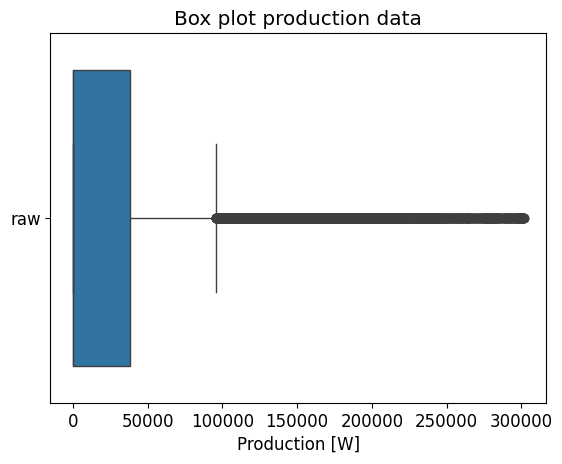

In [164]:
# show box plot

ax = sns.boxplot(data=df[['raw']], orient="h")
plt.title('Box plot production data')
plt.xlabel('Production [W]')
plt.savefig("diagrams/boxplot_production_data.pdf")

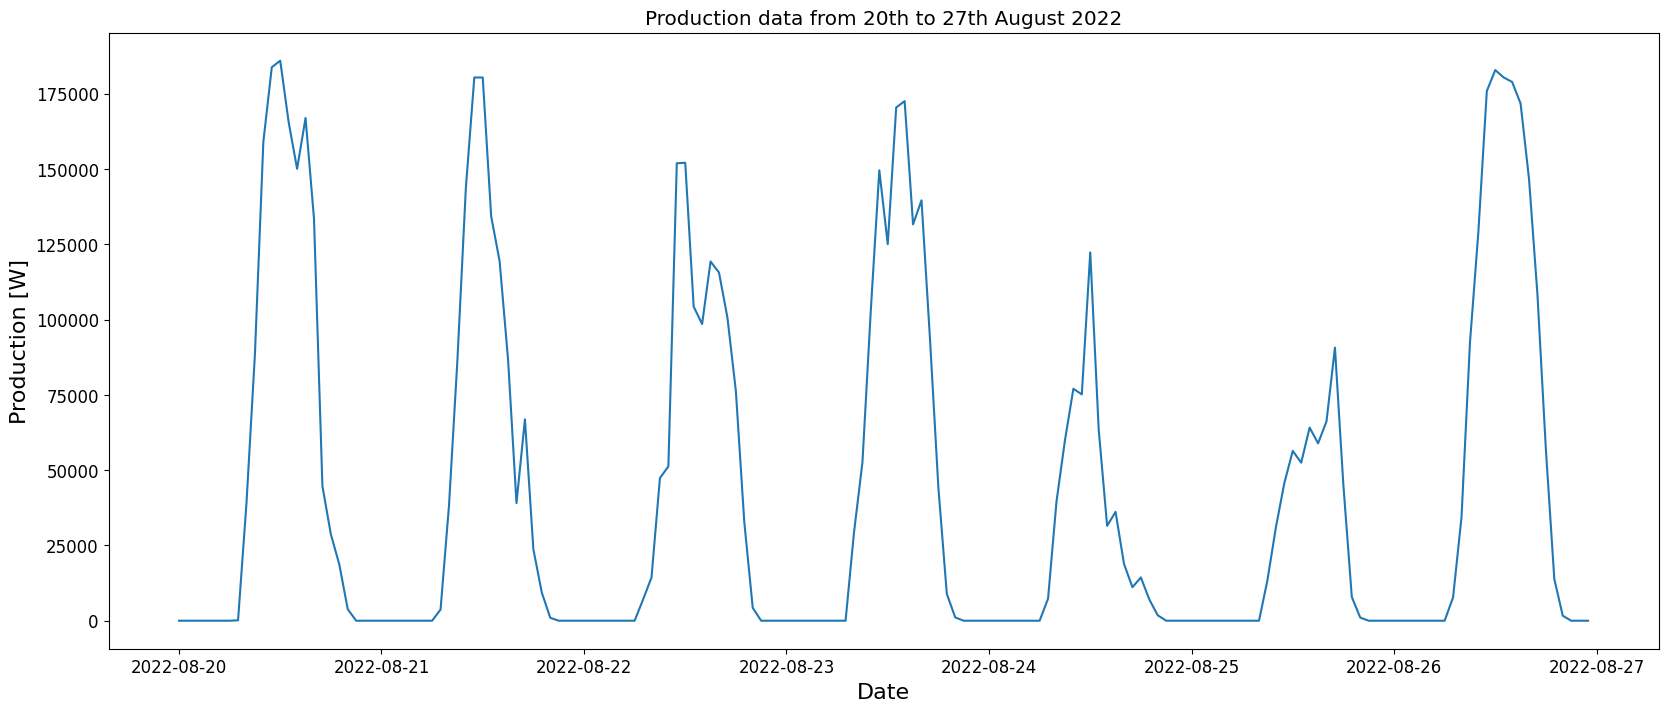

In [165]:
# check raw data over a week
start_date = datetime(2022, 8,20, tzinfo=ZoneInfo("Europe/Tallinn"))
end_date = datetime(2022, 8, 27, tzinfo=ZoneInfo("Europe/Tallinn"))

df_week = df[(df.index >= start_date) & (df.index < end_date)]

plt.figure(figsize=(20,8))
plt.title("Production data from 20th to 27th August 2022")
p = sns.lineplot(data=df_week['raw'])
p.set_xlabel("Date", fontsize=16)
p.set_ylabel("Production [W]", fontsize=16)
plt.savefig("diagrams/diagram_production_data_week.pdf")

Text(0, 0.5, 'Production [W]')

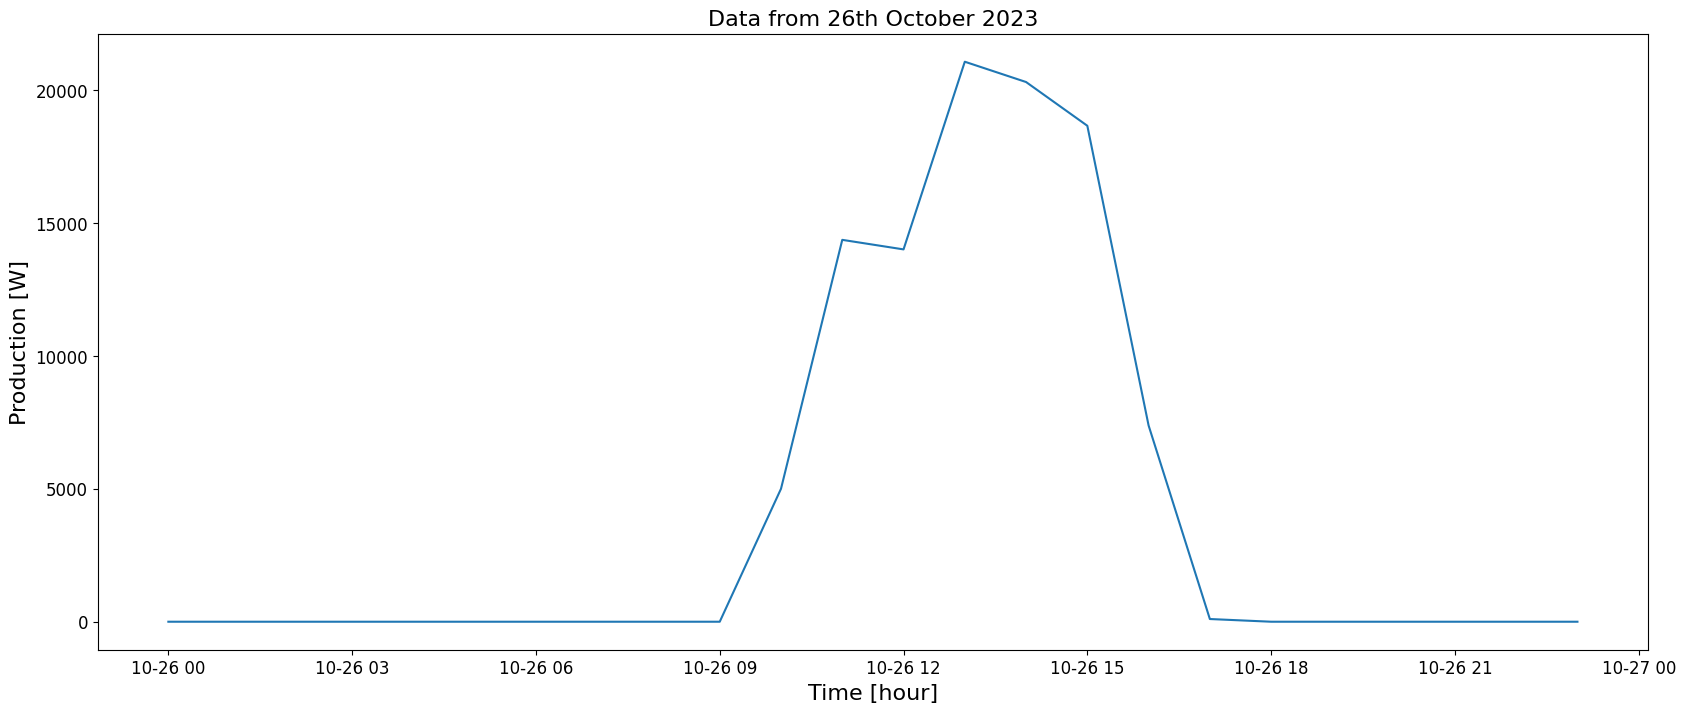

In [166]:
# check raw data over a day
start_date = datetime(2022, 10,26, tzinfo=ZoneInfo("Europe/Tallinn"))
end_date = datetime(2022, 10, 27, tzinfo=ZoneInfo("Europe/Tallinn"))

df_week = df[(df.index >= start_date) & (df.index < end_date)]

plt.figure(figsize=(20,8))
plt.title("Data from 26th October 2023", fontsize=16)
p = sns.lineplot(data=df_week['raw'])
p.set_xlabel("Time [hour]", fontsize=16)
p.set_ylabel("Production [W]", fontsize=16)

## Transformation to normal distribution

1. Without excluding zeros
2. With excluding zeros

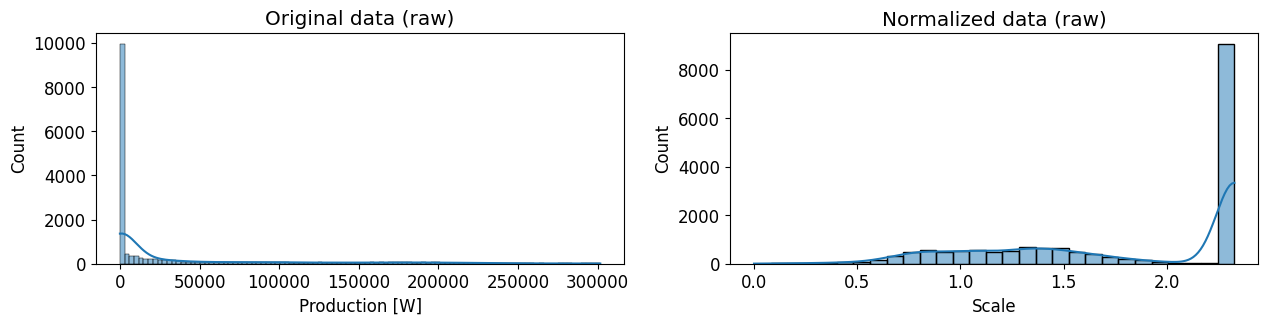

In [167]:
# without excluding zeros
original_data = df['raw']

# fist split data from zero, then fix created left-skewdness
transformation_1 = np.log(original_data+1)
max_trans_1 = max(transformation_1)
transformation_2 = np.pow(max_trans_1 - transformation_1, 1/3)

# plot both together to compare
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
sns.histplot(original_data, ax=ax[0], kde=True, legend=False)
ax[0].set_title("Original data (raw)")
ax[0].set_xlabel("Production [W]")
sns.histplot(transformation_2, ax=ax[1], kde=True, legend=False)
ax[1].set_title("Normalized data (raw)")
ax[1].set_xlabel("Scale")
plt.savefig("diagrams/diagram_normalization.pdf")

/home/niklas/.anaconda3/envs/energy-data-science/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


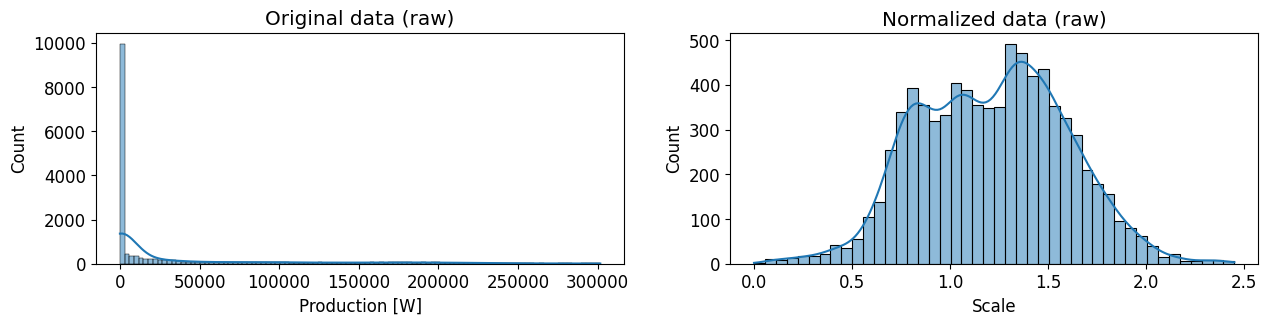

In [168]:
# with excluding zeros
original_data = df['raw']

# fist split data from zero, then fix created left-skewdness
transformation_1 = np.log(original_data)
max_trans_1 = max(transformation_1)
transformation_2 = np.pow(max_trans_1 - transformation_1, 1/3)

# plot both together to compare
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
sns.histplot(original_data, ax=ax[0], kde=True, legend=False)
ax[0].set_title("Original data (raw)")
ax[0].set_xlabel("Production [W]")
sns.histplot(transformation_2, ax=ax[1], kde=True, legend=False)
ax[1].set_title("Normalized data (raw)")
ax[1].set_xlabel("Scale")
plt.savefig("diagrams/diagram_normalization_no_zeroes.pdf")

# Analysis

## Seasonal decompose

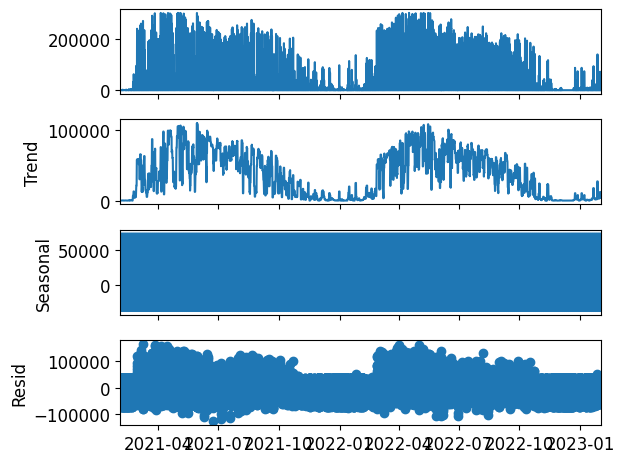

In [169]:
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats

df = filled_data[['raw']]

result=seasonal_decompose(df, model='additive', period=24)
fig = result.plot()
fig.savefig("diagrams/seasonal_decompose.pdf")

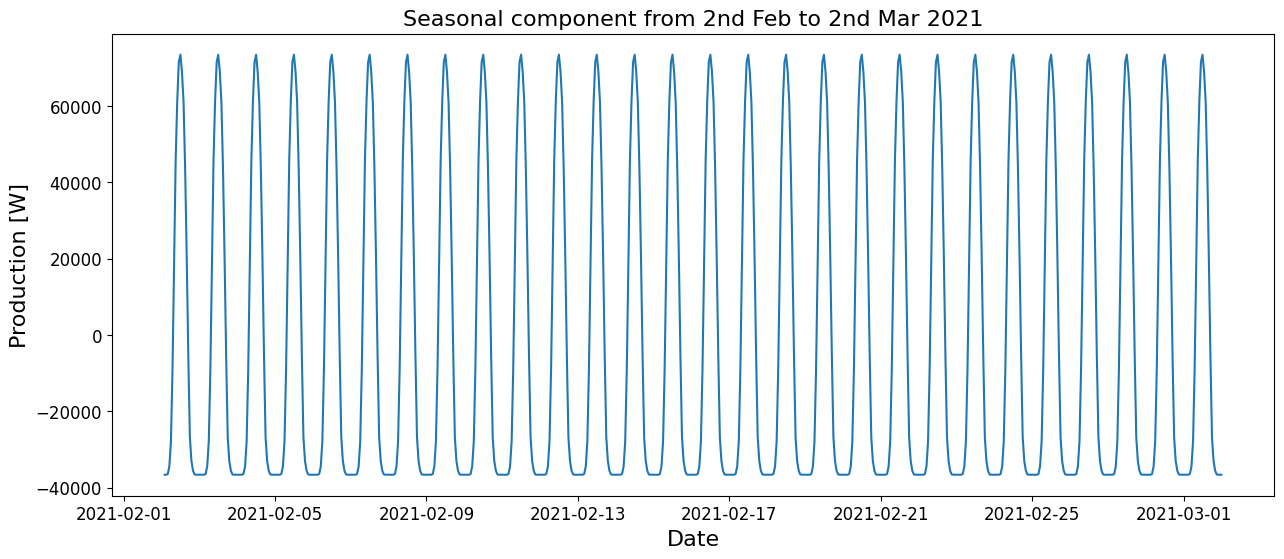

In [170]:
plt.figure(figsize=(15,6))
plt.title("Seasonal component from 2nd Feb to 2nd Mar 2021", fontsize=16)
p = sns.lineplot(data=result.seasonal[result.seasonal.index <= datetime(2021, 3,2, tzinfo=ZoneInfo("Europe/Tallinn"))])
p.set_xlabel("Date", fontsize=16)
p.set_ylabel("Production [W]", fontsize=16)
plt.savefig("diagrams/seasonal_component.pdf")

## Profile generation

Generate profiles of average daily production of each month

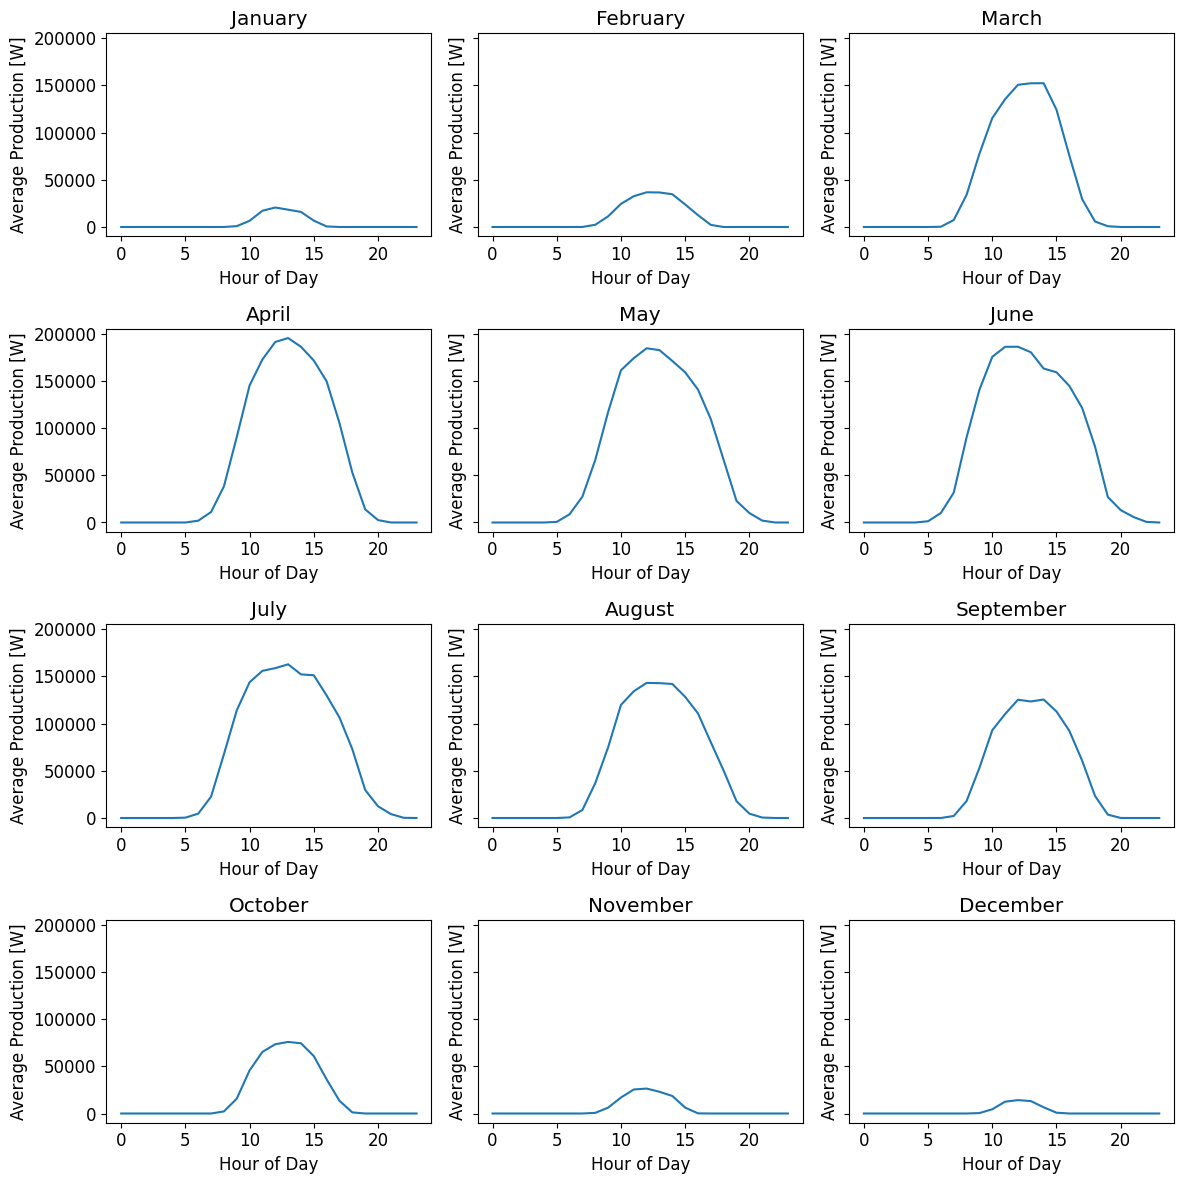

In [171]:
filled_data['month'] = filled_data.index.month
filled_data['hour'] = filled_data.index.hour

months_labels = ["January", "February", "March", "April", "May", "June", "July", "August", "September","October", "November", "December"]

# Group by month and hour, then calculate the mean for each month-hour combination
monthly_avg = filled_data.groupby(['month', 'hour'])['raw'].mean().reset_index()

# Plotting for each month
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 12), sharey=True)
axes = axes.flatten()

for month in range(1, 13):
    ax = axes[month-1]
    month_data = monthly_avg[monthly_avg['month'] == month]
    
    ax.plot(month_data['hour'], month_data['raw'])
    ax.set_title(months_labels[month-1])
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Average Production [W]')

plt.tight_layout()
plt.savefig("diagrams/profiles_months.pdf")